# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109B Data Science 2: Advanced Topics in Data Science 
## Homework 4 - RNN



**Harvard University**<br/>
**Spring 2019**<br/>
**Instructors**: Mark Glickman and Pavlos Protopapas 


<hr style="height:2pt">

In [61]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

<span style="color:red">**Model training can be very slow; start doing this HW early**</span>

- To submit your assignment follow the instructions given in Canvas.

- This homework can be submitted in pairs.

- If you submit individually but you have worked with someone, please include the name of your **one** partner below.
- Please restart the kernel and run the entire notebook again before you submit.

**Names of person you have worked with goes here: Xiyu Ding**
<br><BR>

<div class="theme"> Overview: Named Entity Recognition Challenge</div>

Named entity recognition (NER) seeks to locate and classify named entities present in unstructured text into predefined categories such as organizations, locations, expressions of times, names of persons, etc. This technique is often used in real use cases such as classifying content for news providers, efficient search algorithms over large corpora and content-based recommendation systems. 

This represents an interesting "many-to-many" problem, allowing us to experiment with recurrent architectures and compare their performances against other models.


In [62]:
import pandas as pd
import numpy as np

from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA


import matplotlib.pyplot as plt
plt.style.use("ggplot")


In [63]:
import keras
import tensorflow as tf

from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical,np_utils
from keras import backend

from keras.models import Model, Input, Sequential,model_from_json
from keras.layers import SimpleRNN, Embedding, Dense, TimeDistributed, GRU, \
                         Dropout, Bidirectional, Conv1D, BatchNormalization, \
                         MaxPooling1D,Flatten, GlobalMaxPooling1D


print(keras.__version__)
print(tf.__version__)

2.2.4
1.12.0


In [64]:
# Set seed for repeatable results
np.random.seed(123)
tf.set_random_seed(456)

In [65]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

<div class='explication'> </div>


## Part 1: Read the data

Read in data ```HW4_data.csv``` and use the  code below to open the csv as a pandas dataframe.

As you can see, we have a dataset with sentences (```Sentence #``` column), each composed of words (```Word``` column) with part-of-speech tagging (```POS``` tagging) and inside–outside–beginning (IOB) named entity tags (```Tag``` column) attached. ```POS``` will not be used for this homework. We will predict ```Tag``` using only the words themselves.

Essential info about entities:
* geo = Geographical Entity
* org = Organization
* per = Person
* gpe = Geopolitical Entity
* tim = Time indicator
* art = Artifact
* eve = Event
* nat = Natural Phenomenon

IOB prefix:
* B: beginning of named entity
* I: inside of named entity
* O: outside of named entity

In [140]:
# Given code
path_dataset = './data/HW4_data.csv'
data = pd.read_csv(path_dataset, encoding="latin1")
data = data.fillna(method="ffill")
data.head(15)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


<div class='exercise'><b> Question 1.  Prepare Data [20pt]</b></div>


<span class='sub-q'> **Question 1.1**</span> 
* (1) Create a list of unique words found in column 'Word'
* (2) Sort the list in alphabetic order
* (3) Append the special word "ENDPAD" to the end of the list, and store it to a variable ```words```
* (4) Store the length of this list to a variable ```n_words```

In [141]:
words = sorted(data["Word"].unique(), key=str.lower)
words.append("ENDPAD")
n_words = len(words)

In [142]:
n_words

35179

<span class='sub-q'>**Question 1.2**</span>
* (1) Store a list of unique tags into a variable ```tags```, paying attention to sort the list in alphabetic order
* (2) Append the special tag "PAD" to the end of the list
* (3) Store the length of this list to a variable ```n_tags```

In [143]:
# tags = sorted(data["Tag"].unique(), key = str.lower)
tags = sorted(data["Tag"].unique())
tags.append("PAD")
n_tags = len(tags)

<span class='sub-q'>**Question 1.3**</span>
* (1) Process data into a list of sentences, each sentence is a list of (word, tag) tuples.

**Example**

First sentence in the list of sentences:

[('Thousands', 'O'),
 ('of',  'O'),
 ('demonstrators', 'O'),
 ('have', 'O'),
 ('marched', 'O'),
 ('through', 'O'),
 ('London', 'B-geo'),
 ('to', 'O'),
 ('protest', 'O'),
 ('the', 'O'),
 ('war', 'O'),
 ('in', 'O'),
 ('Iraq', 'B-geo'),
 ('and', 'O'),
 ('demand', 'O'),
 ('the', 'O'),
 ('withdrawal', 'O'),
 ('of', 'O'),
 ('British', 'B-gpe'),
 ('troops', 'O'),
 ('from', 'O'),
 ('that', 'O'),
 ('country', 'O'),
 ('.', 'O')]
* (2) Find out the number of words in the longest sentence, and store it to variable ```max_len```


In [144]:
sentence_idx = data["Sentence #"].unique()

In [145]:
data['tuples'] = list(zip(data["Word"], data["Tag"]))
sentence_list = list(data.groupby('Sentence #')['tuples'].apply(list))

In [146]:
sentence_list[0]

[('Thousands', 'O'),
 ('of', 'O'),
 ('demonstrators', 'O'),
 ('have', 'O'),
 ('marched', 'O'),
 ('through', 'O'),
 ('London', 'B-geo'),
 ('to', 'O'),
 ('protest', 'O'),
 ('the', 'O'),
 ('war', 'O'),
 ('in', 'O'),
 ('Iraq', 'B-geo'),
 ('and', 'O'),
 ('demand', 'O'),
 ('the', 'O'),
 ('withdrawal', 'O'),
 ('of', 'O'),
 ('British', 'B-gpe'),
 ('troops', 'O'),
 ('from', 'O'),
 ('that', 'O'),
 ('country', 'O'),
 ('.', 'O')]

In [147]:
# Run this cell to show your results #
max_len = max(data.groupby('Sentence #').size())
print(max_len)

104


<span class='sub-q'>**Question 1.4**</span>

It's now time to convert the sentences data in a suitable format for the RNNs training/evaluation procedures. To this end, you are required to:
* (1) Create a ```word2idx``` dictionary mapping distinct words from the dataset into distinct integers. Also create a ```idx2word``` dictionary. 
* (2) Prepare the predictors matrix ```X```, as a list of lists, where each inner list is a sequence of words mapped into integers accordly to the ```word2idx``` dictionary. 
* (3) Apply the keras ```pad_sequences``` function to standardize the predictors. You should retrieve a matrix with all padded sentences and length equal to ```max_len``` previously computed. The dimensionality should therefore be equal to ```[# of sentences, max_len]```

Your ```X[i]``` now should be something similar to this:

```[ 8193 27727 31033 33289 22577 33464 23723 16665 33464 31142 31319 28267
 27700 33246 28646 16052    21 16915 17349  7924 32879 32985 18238 23555
    24 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178]```
 
* (4) Create a ```tag2idx``` dictionary mapping distinct named entity tags from the dataset into distinct integers. Also create a ```idx2tag``` dictionary.

* (5) Prepare targets matrix ```Y```, as a list of lists,where each inner list is a sequence of tags mapped into integers accordly to the ```tag2idx``` dictionary.
* (6) apply the keras ```pad_sequences``` function to standardize the targets. Inject the ```PAD``` tag for the padding words. You should retrieve a matrix with all padded sentences'tags and length equal to ```max_length``` previously computed. 

* (7) Use the ```to_categorical``` keras function to one-hot encode the tags.

Now your ```Y``` should have dimension ```[# of sentences, max_len, n_tags]```

* (8) Split the dataset in train and test datasets (test 10%).

<div class='explication'> </div>

In [148]:
# your code #
word2idx = {}
for i in range(n_words):
    word2idx[words[i]] = i
    
idx2word = {}
for i in range(n_words):
    idx2word[i] = words[i]

In [149]:
data['Word_map'] = data['Word']
data['Word_map'] = data["Word_map"].map(word2idx)

In [150]:
word_list = list(data.groupby('Sentence #')['Word_map'].apply(list))

In [151]:
X = word_list

In [152]:
X = pad_sequences(word_list, maxlen=max_len, padding='post', value = word2idx["ENDPAD"])

In [153]:
X.shape

(47959, 104)

In [154]:
tag2idx = {}
for i in range(n_tags):
    tag2idx[tags[i]] = i
    
idx2tag = {}
for i in range(n_tags):
    idx2tag[i] = tags[i]
    
data['Tag_map'] = data['Tag']
data['Tag_map'] = data["Tag_map"].map(tag2idx)

In [155]:
tag_list = list(data.groupby('Sentence #')['Tag_map'].apply(list))
Y = tag_list
Y = pad_sequences(tag_list, maxlen=max_len, padding='post', value = tag2idx["PAD"])

In [156]:
Y = to_categorical(Y, num_classes = n_tags)

In [157]:
Y.shape

(47959, 104, 18)

In [158]:
# Run this cell to show your results #
print("The index of word 'Harvard' is: {}\n".format(word2idx["Harvard"]))
print("Sentence 1: {}\n".format(X[1]))
print(X.shape)

The index of word 'Harvard' is: 15108

Sentence 1: [17034 22706 27999 31745 12168 32026 14040  2259 32026 28192 28450 23612
 22672 31679 24263 34245    21  2657  3453 16032 30958 31127  5221 13654
    24 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178]

(47959, 104)


In [159]:
# Run this cell to show your results #
print("The index of tag 'B-gpe' is: {}\n".format(tag2idx["B-gpe"]))
print("The tag of the last word in Sentence 1: {}\n".format(Y[0][-1]))
print(np.array(Y).shape)

The index of tag 'B-gpe' is: 3

The tag of the last word in Sentence 1: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]

(47959, 104, 18)


In [160]:
indices = range(X.shape[0])
X_train, X_test, y_train, y_test, idx_train, idx_test  = train_test_split(X, Y, indices,
                                                                          test_size=0.1, 
                                                                          random_state=42)

In [161]:
X_train.shape, y_train.shape

((43163, 104), (43163, 104, 18))

## Part 2: Modelling

After preparing the train and test sets, we are ready to build five models: 
* frequency-based baseline 
* vanilla feedforward neural network
* recurrent neural network
* gated recurrent neural network
* bidirectional gated recurrent neural network

More details are given about architecture in each model's section. The input/output dimensionalities will be the same for all models:
* input: ```[# of sentences, max_len]```
* output: ```[# of sentences, max_len, n_tags]```

Follow the information in each model's section to set up the architecture of each model. And the end of each training, use the given ```store_model``` function to store the weights and architectures in the ```./models``` path for later testing;```load_keras_model()``` is also provided to you

A further ```plot_training_history``` helper function is given in case you need to check the training history.


In [162]:
# Store model
def store_keras_model(model, model_name):
    model_json = model.to_json() # serialize model to JSON
    with open("./models/{}.json".format(model_name), "w") as json_file:
        json_file.write(model_json)
    model.save_weights("./models/{}.h5".format(model_name)) # serialize weights to HDF5
    print("Saved model to disk")
    
# Plot history
def plot_training_history(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1,len(loss)+1)

    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()

In [163]:
# Load model 
def load_keras_model(model_name):
    # Load json and create model
    json_file = open('./models/{}.json'.format(model_name), 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json)
    # Load weights into new model
    model.load_weights("./models/{}.h5".format(model_name))
    return model

<div class='exercise'><b>Question 2: Models [40pt]</b></div>

<span class='sub-q'>**Question 2.1**</span>

### Model 1: Baseline Model ###

Predict the tag of a word simply with the most frequently-seen named entity tag of this word from the training set.

e.g. word "Apple" appears 10 times in the training set; 7 times it was tagged as "Corporate" and 3 times it was tagged as "Fruit". If we encounter the word "Apple" in the test set, we predict it as "Corporate".

**Create an np.array ```baseline``` of length [n_words]**
where the ith element   ```baseline[i]``` is the index of the most commonly seen named entity tag of word i summarised from training set.   (e.g. [16, 16, 16, ..., 0, 16, 16])




<div class='explication'> </div>

In [164]:
# your code #
tag_mat = np.empty([n_words,n_tags])
baseline = np.zeros(n_words)

for i in range(X_train.shape[0]):
    for j in range(X_train.shape[1]):
        word = X_train[i,j]
        tag_mat[word,:] = tag_mat[word,:] + y_train[i,j,:]

for i in range(n_words):
    baseline[i] = np.argmax(tag_mat[i,:])
    if sum(tag_mat[i,:]) == 0:
        baseline[i] == 16

In [165]:
# Run this cell to show your results #
print(baseline[X].shape,'\n')
print('Sentence:\n {}\n'.format([idx2word[w] for w in X[0]]))
print('Predicted Tags:\n {}'.format([idx2tag[i] for i in baseline[X[0]]]))

(47959, 104) 

Sentence:
 ['Thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'London', 'to', 'protest', 'the', 'war', 'in', 'Iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'British', 'troops', 'from', 'that', 'country', '.', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDP

### Model 2: Vanilla Feed Forward Neural Network ###

This model is provided to you. Please pay attention to the architecture of this neural network, especially the input/output dimensionalities and the Embedding layer.



<span class='sub-q'>**Question 2.2**</span>

(1) Explain what is embedding layer and why we need it here.

(2) Explain why the Param # of Embedding layer is 1758950 (as shown in ```print(model.summary())```).

**(1) An embedding is a linear projection from one vector space to another. We usually use embeddings to project the one-hot encodings of words on to a lower-dimensional continuous space so that the input surface is dense and possibly smooth. According to the model, an embedding layer is just a transformation from $\mathbb{R}^{inp}$ to $\mathbb{R}^{emb}$.             
(2) The number of parameter of embedding layer (1758950) = n_words$*$dim_embed. **

### Hyperparameters shared with other NN models

In [166]:
n_units = 100
drop_rate = .1
dim_embed = 50

optimizer = "rmsprop"
loss = "categorical_crossentropy"
metrics = ["accuracy"]

batch_size = 32
epochs = 10
validation_split = 0.1
verbose = 1

In [32]:
# use clear_session to start a new model #
backend.clear_session()

# Define model
model=Sequential()
model.add(Embedding(input_dim=n_words, output_dim=dim_embed, input_length=max_len))
model.add(Dropout(drop_rate))
model.add(Dense(n_tags, activation="softmax"))

# Compile model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [33]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 104, 50)           1758950   
_________________________________________________________________
dropout_1 (Dropout)          (None, 104, 50)           0         
_________________________________________________________________
dense_1 (Dense)              (None, 104, 18)           918       
Total params: 1,759,868
Trainable params: 1,759,868
Non-trainable params: 0
_________________________________________________________________
None


In [36]:
# Train model
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, 
                    validation_split=validation_split, verbose=verbose)

In [35]:
store_keras_model(model, 'model_FFNN')

Saved model to disk


In [37]:
plot_training_history(history)

NameError: name 'history' is not defined

In addition to the final result, we also want to see the intermediate results from hidden layers. Below is an example showing how to get outputs from a hidden layer, and visualize them on the reduced dimension of 2D by PCA. (**Please note that these codes and parameters cannot be simply copied and pasted for other questions; some adjustments need to be made**) 

In [38]:
FFNN=load_keras_model('model_FFNN')

def create_truncated_model_FFNN(trained_model):
    model=Sequential()
    model.add(Embedding(input_dim=n_words, output_dim=dim_embed, input_length=max_len))
    model.add(Dropout(drop_rate))
    # set weights of first few layers using the weights of trained model
    for i, layer in enumerate(model.layers):
        layer.set_weights(trained_model.layers[i].get_weights())
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model
truncated_model = create_truncated_model_FFNN(FFNN)
hidden_features = truncated_model.predict(X_test)

# flatten data
hidden_features=hidden_features.reshape(-1,50)
y_te=y_test.reshape(-1,18)
 
# find first two PCA components
pca = PCA(n_components=2)
pca_result = pca.fit_transform(hidden_features)
print('Variance explained by PCA: {}'.format(np.sum(pca.explained_variance_ratio_)))

Variance explained by PCA: 0.9363466393921707


In [39]:
# visualize hidden featurs on first two PCA components
# this plot only shows B-tags
def visualize_hidden_features(pca_result):
    color=['r', 'C1', 'y', 'C3', 'b', 'g', 'm', 'orange']
    category = np.argmax(y_te, axis=1)
    fig, ax = plt.subplots()
    fig.set_size_inches(6,6)    
    for cat in range(8):
        indices_B = np.where(category==cat)[0]
        #length=min(1000,len(indices_B))
        #indices_B=indices_B[:length]
        ax.scatter(pca_result[indices_B,0], pca_result[indices_B, 1], label=idx2tag[cat],s=2,color=color[cat],alpha=0.5)
        legend=ax.legend(markerscale=3)
        legend.get_frame().set_facecolor('w')  
    plt.show()

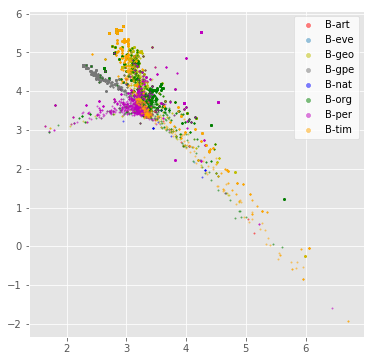

In [36]:
visualize_hidden_features(pca_result)

### Model 3: RNN ###
<span class='sub-q'>**Question 2.3**</span>

(1) Set up a simple RNN model by stacking the following layers in sequence:
* an input layer
* a simple Embedding layer transforming integer words into vectors 
* a dropout layer to regularize the model
* a SimpleRNN layer 
* a TimeDistributed layer with an inner Dense layer which output dimensionality is equal to n_tag

(2) Compile the model

(3) Train the model and plot the training history

(4) Visualize outputs from SimpleRNN layer, one subplot for **B-tags** and one subplot for **I-tags**,comment on the patterns you observed.

For hyperparameters use those provided in Model 2

<div class='explication'> </div>

In [37]:
from keras import layers

# use clear_session to start a new model #
backend.clear_session()

# Define model
model=Sequential()
model.add(Embedding(input_dim=n_words, output_dim=dim_embed, input_length=max_len))
model.add(Dropout(drop_rate))
model.add(SimpleRNN(n_units, return_sequences=True))
model.add(TimeDistributed(Dense(output_dim=n_tags, activation='softmax')))

# Compile model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

/usr/share/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=18)`
  # This is added back by InteractiveShellApp.init_path()


In [41]:
# Train model
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, 
                    validation_split=validation_split, verbose=verbose)

Train on 38846 samples, validate on 4317 samples
Epoch 1/10
38846/38846 [==============================] - 82s 2ms/step - loss: 0.0981 - acc: 0.9753 - val_loss: 0.0346 - val_acc: 0.9898
Epoch 2/10
38846/38846 [==============================] - 82s 2ms/step - loss: 0.0294 - acc: 0.9912 - val_loss: 0.0307 - val_acc: 0.9908
Epoch 3/10
38846/38846 [==============================] - 81s 2ms/step - loss: 0.0260 - acc: 0.9922 - val_loss: 0.0285 - val_acc: 0.9914
Epoch 4/10
38846/38846 [==============================] - 81s 2ms/step - loss: 0.0243 - acc: 0.9927 - val_loss: 0.0279 - val_acc: 0.9915
Epoch 5/10
38846/38846 [==============================] - 81s 2ms/step - loss: 0.0231 - acc: 0.9931 - val_loss: 0.0280 - val_acc: 0.9915
Epoch 6/10
38846/38846 [==============================] - 81s 2ms/step - loss: 0.0222 - acc: 0.9934 - val_loss: 0.0276 - val_acc: 0.9917
Epoch 7/10
38846/38846 [==============================] - 81s 2ms/step - loss: 0.0213 - acc: 0.9936 - val_loss: 0.0280 - val_acc:

In [43]:
# save your mode ##
store_keras_model(model, 'model_RNN')

Saved model to disk


In [44]:
# run this cell to show your results #
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 104, 50)           1758950   
_________________________________________________________________
dropout_1 (Dropout)          (None, 104, 50)           0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 104, 100)          15100     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 104, 18)           1818      
Total params: 1,775,868
Trainable params: 1,775,868
Non-trainable params: 0
_________________________________________________________________
None


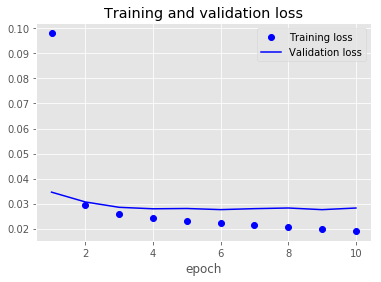

In [45]:
# run this cell to show your results #
plot_training_history(history)

In [106]:
# visualization of hidden features
def create_truncated_model_RNN(trained_model):
    model=Sequential()
    model.add(Embedding(input_dim=n_words, output_dim=dim_embed, input_length=max_len))
    model.add(Dropout(drop_rate))
    model.add(SimpleRNN(n_units, return_sequences=True))
    # set weights of first few layers using the weights of trained model
    for i, layer in enumerate(model.layers):
        layer.set_weights(trained_model.layers[i].get_weights())
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model

rnn=load_keras_model('model_RNN')
truncated_model = create_truncated_model_RNN(rnn)
hidden_features = truncated_model.predict(X_test)

# flatten data
hidden_features=hidden_features.reshape(-1,100)
y_te=y_test.reshape(-1,18)
 
# find first two PCA components
pca = PCA(n_components=2)
pca_result = pca.fit_transform(hidden_features)
print('Variance explained by PCA: {}'.format(np.sum(pca.explained_variance_ratio_)))

Variance explained by PCA: 0.829578249186458


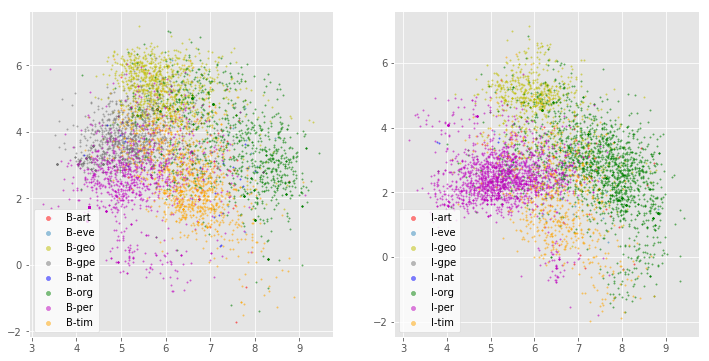

In [107]:
def visualize_hidden_features(pca_result):
    color=['r', 'C1', 'y', 'C3', 'b', 'g', 'm', 'orange']
    category = np.argmax(y_te, axis=1)
    fig, ax = plt.subplots(1,2)
    fig.set_size_inches(12,6)    
    for cat in range(8): 
        indices_B = np.where(category==cat)[0]
        indices_I = np.where(category==cat+8)[0]
        length=min(1000,len(indices_B))
        indices_B=indices_B[:length]
        ax[0].scatter(pca_result[indices_B,0], pca_result[indices_B, 1], label=idx2tag[cat],s=2,color=color[cat],alpha=0.5)
        ax[1].scatter(pca_result[indices_I,0], pca_result[indices_I, 1], label=idx2tag[cat+8],s=2,color=color[cat],alpha=0.5)
        legend0=ax[0].legend(markerscale=3)
        legend0.get_frame().set_facecolor('w') 
        legend1=ax[1].legend(markerscale=3)
        legend1.get_frame().set_facecolor('w')
    plt.show()
    
visualize_hidden_features(pca_result)

**Based on the PCA plots above, for both B-tags and I-tags, there are four types of tags that are separated from each other, which are 'X-per', 'X-geo', 'X-tim' and 'X-org', forming four clusters. The rest of tags are mixed up within these four clusters. ** 

### Model 4: GRU ###

<span class='sub-q'>**Question 2.4**</span>


(1) Briefly explain what is GRU and how it is different from simple RNN

(2) build a GRU architecture by replacing the SimpleRNN cell with a GRU one. 

(3) Compile the model

(4) Train the model and plot the training history

(5) Visualize outputs from GRU layer, one subplot for **B-tags** and one subplot for **I-tags**, comment on the patterns you observed.

<div class='explication'> </div>

In [121]:
# use clear_session to start a new model #
backend.clear_session()

# Define model
model=Sequential()
model.add(Embedding(input_dim=n_words, output_dim=dim_embed, input_length=max_len))
model.add(Dropout(drop_rate))
model.add(GRU(100,return_sequences=True))
model.add(TimeDistributed(Dense(output_dim=n_tags, activation='softmax')))

# Compile model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

/usr/share/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=18)`
  if __name__ == '__main__':


In [47]:
# Train model
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, 
                    validation_split=validation_split, verbose=verbose)

Train on 38846 samples, validate on 4317 samples
Epoch 1/10
38846/38846 [==============================] - 169s 4ms/step - loss: 0.0924 - acc: 0.9777 - val_loss: 0.0340 - val_acc: 0.9900
Epoch 2/10
38846/38846 [==============================] - 168s 4ms/step - loss: 0.0291 - acc: 0.9914 - val_loss: 0.0294 - val_acc: 0.9912
Epoch 3/10
38846/38846 [==============================] - 168s 4ms/step - loss: 0.0257 - acc: 0.9924 - val_loss: 0.0281 - val_acc: 0.9916
Epoch 4/10
38846/38846 [==============================] - 169s 4ms/step - loss: 0.0240 - acc: 0.9929 - val_loss: 0.0273 - val_acc: 0.9917
Epoch 5/10
38846/38846 [==============================] - 169s 4ms/step - loss: 0.0227 - acc: 0.9933 - val_loss: 0.0269 - val_acc: 0.9919
Epoch 6/10
38846/38846 [==============================] - 169s 4ms/step - loss: 0.0217 - acc: 0.9935 - val_loss: 0.0266 - val_acc: 0.9919
Epoch 7/10
38846/38846 [==============================] - 168s 4ms/step - loss: 0.0209 - acc: 0.9938 - val_loss: 0.0266 - v

In [48]:
# save your model #
store_keras_model(model, 'model_GRU')

Saved model to disk


In [49]:
# run this cell to show your results #
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 104, 50)           1758950   
_________________________________________________________________
dropout_1 (Dropout)          (None, 104, 50)           0         
_________________________________________________________________
gru_1 (GRU)                  (None, 104, 100)          45300     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 104, 18)           1818      
Total params: 1,806,068
Trainable params: 1,806,068
Non-trainable params: 0
_________________________________________________________________
None


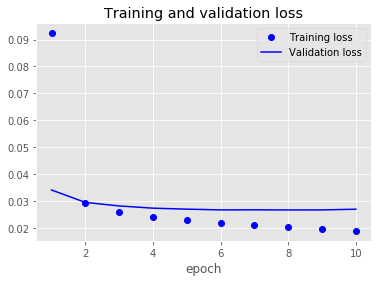

In [50]:
# run this cell to show your results #
plot_training_history(history)

In [120]:
# visualization of hidden features
def create_truncated_model_GRU(trained_model):
    model=Sequential()
    model.add(Embedding(input_dim=n_words, output_dim=dim_embed, input_length=max_len))
    model.add(Dropout(drop_rate))
    model.add(GRU(100,return_sequences=True))
    # set weights of first few layers using the weights of trained model
    for i, layer in enumerate(model.layers):
        layer.set_weights(trained_model.layers[i].get_weights())
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model

gru=load_keras_model('model_GRU')
truncated_model = create_truncated_model_GRU(gru)
hidden_features = truncated_model.predict(X_test)

# flatten data
hidden_features=hidden_features.reshape(-1,100)
y_te=y_test.reshape(-1,18)
 
# find first two PCA components
pca = PCA(n_components=2)
pca_result = pca.fit_transform(hidden_features)
print('Variance explained by PCA: {}'.format(np.sum(pca.explained_variance_ratio_)))

Variance explained by PCA: 0.8159950100452243


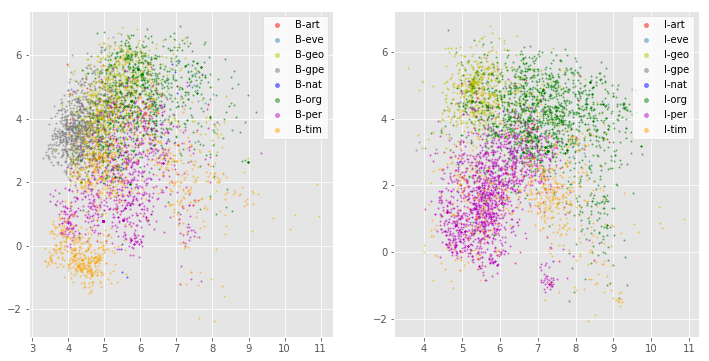

In [121]:
visualize_hidden_features(pca_result)

**Based on the PCA plots above, for the B-tags, all tags are mixed up together and not separated clearly. But we can still see there are two ambiguous clusters. One is composed of 'B-geo', 'B-gpe', 'B-nat', and the other is composed of 'B-per'and 'B-tim'. 
While for both I-tags, they are more separated than B-tags. Among all I-tags, 'I-geo', 'I-org' and 'I-per' are more clearly separated from each other, forming three clusters. ** 

<div class='explication'> </div>

### Model 5: Bidirectional GRU ###
<span class='sub-q'>**Question 2.5**</span>


(1) Explain what is Bidirectional GRU and how it is different from GRU model above.

(2) Then build a bidirectional GRU by wrapping your GRU layer into a Bidirectional one

(3) Compile the model

(4) Train the model and plot the training history

(5) Visualize outputs from bidirectional GRU layer, one subplot for **B-tags** and one subplot for **I-tags**, comment on the patterns you observed.

In [125]:
# use clear_session to start a new model #
backend.clear_session()

# Define model
model=Sequential()
model.add(Embedding(input_dim=n_words, output_dim=dim_embed, input_length=max_len))
model.add(Dropout(drop_rate))
model.add(Bidirectional(layers.GRU(100, return_sequences=True)))
model.add(TimeDistributed(Dense(output_dim=n_tags, activation='softmax')))

# Compile model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

/usr/share/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=18)`
  if __name__ == '__main__':


In [126]:
# Train model
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, 
                    validation_split=validation_split, verbose=verbose)

Train on 38846 samples, validate on 4317 samples
Epoch 1/10
38846/38846 [==============================] - 320s 8ms/step - loss: 0.0741 - acc: 0.9813 - val_loss: 0.0283 - val_acc: 0.9916
Epoch 2/10
38846/38846 [==============================] - 319s 8ms/step - loss: 0.0244 - acc: 0.9929 - val_loss: 0.0243 - val_acc: 0.9928
Epoch 3/10
38846/38846 [==============================] - 318s 8ms/step - loss: 0.0209 - acc: 0.9938 - val_loss: 0.0232 - val_acc: 0.9931
Epoch 4/10
38846/38846 [==============================] - 320s 8ms/step - loss: 0.0190 - acc: 0.9944 - val_loss: 0.0226 - val_acc: 0.9933
Epoch 5/10
38846/38846 [==============================] - 319s 8ms/step - loss: 0.0177 - acc: 0.9947 - val_loss: 0.0226 - val_acc: 0.9933
Epoch 6/10
38846/38846 [==============================] - 319s 8ms/step - loss: 0.0166 - acc: 0.9951 - val_loss: 0.0223 - val_acc: 0.9934
Epoch 7/10
38846/38846 [==============================] - 320s 8ms/step - loss: 0.0156 - acc: 0.9954 - val_loss: 0.0225 - v

In [127]:
# save your model #
store_keras_model(model, 'model_BiGRU')

Saved model to disk


In [129]:
# run this cell to show your results #
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 104, 50)           1758950   
_________________________________________________________________
dropout_1 (Dropout)          (None, 104, 50)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 104, 200)          90600     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 104, 18)           3618      
Total params: 1,853,168
Trainable params: 1,853,168
Non-trainable params: 0
_________________________________________________________________
None


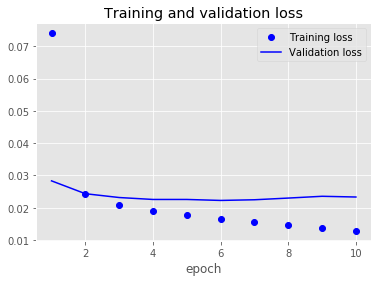

In [130]:
# run this cell to show your results #
plot_training_history(history)

In [122]:
def create_truncated_model_BiGRU(trained_model):
    model=Sequential()
    model.add(Embedding(input_dim=n_words, output_dim=dim_embed, input_length=max_len))
    model.add(Dropout(drop_rate))
    model.add(Bidirectional(GRU(100, return_sequences=True)))
    # set weights of first few layers using the weights of trained model
    for i, layer in enumerate(model.layers):
        layer.set_weights(trained_model.layers[i].get_weights())
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model

Variance explained by PCA: 0.7831679187269054


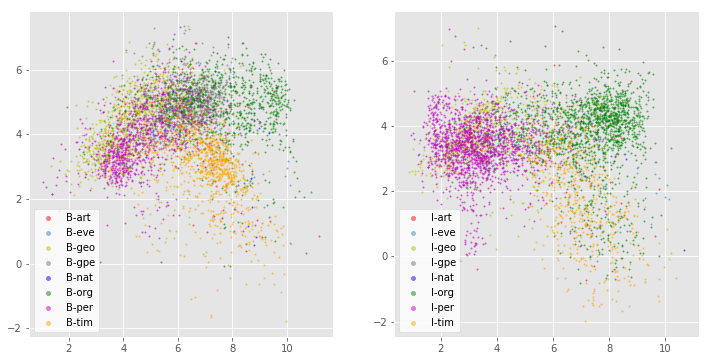

In [123]:
# visualization of hidden features
BiGRU=load_keras_model('model_BiGRU')
truncated_model = create_truncated_model_BiGRU(BiGRU)
hidden_features = truncated_model.predict(X_test)

# flatten data
hidden_features=hidden_features.reshape(-1,200)
y_te=y_test.reshape(-1,18)
 
# find first two PCA components
pca = PCA(n_components=2)
pca_result = pca.fit_transform(hidden_features)
print('Variance explained by PCA: {}'.format(np.sum(pca.explained_variance_ratio_)))

visualize_hidden_features(pca_result)

**Based on the PCA plots above, for both B-tags and I-tags, 'X-per', 'X-org' and 'X-tim' tags have much larger amounts than other tags, and they are separated, though not completely, forming three clusters. Other tags do not form any clear clusters that separated from these three clusters. **

<div class='exercise'><b> Question 3: Analysis [40pt]</b></div>


<span class='sub-q'>**Question 3.1**</span>


For each model iteratively:

(1) Load the model using the given function ```load_keras_model```

(2) Apply the model to the test dataset

(3) Compute an F1 score for each ```Tag``` and store it 

(4) Plot the F1 score per Tag and per model making use of a grouped barplot.

(5) Briefly discuss the performance of each model

In [116]:
def group_bar(model_name):
    score=[]
    score_list={}
    y_te=y_test.reshape(-1,18)

    for name in model_name:
        if name == 'Baseline':
            y_pred = baseline[X_test]
        else:
            model = load_keras_model(name)
            y_pred = model.predict_classes(X_test)
        # Convert y_pred from 2d to 3d
        y_pred_3d = (np.arange(y_pred.max()+1) == y_pred[...,None]).astype(int)
        y_pr=y_pred_3d.reshape(-1,18)
        score = f1_score(y_pr, y_te, average=None)
        score_list[name]=score
    
    score_plot = pd.DataFrame(score_list, index=tags)
    ax = score_plot.plot.bar(rot=0, figsize=(16,8), colormap='Set3')
    ax.set_facecolor('white')

/usr/share/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


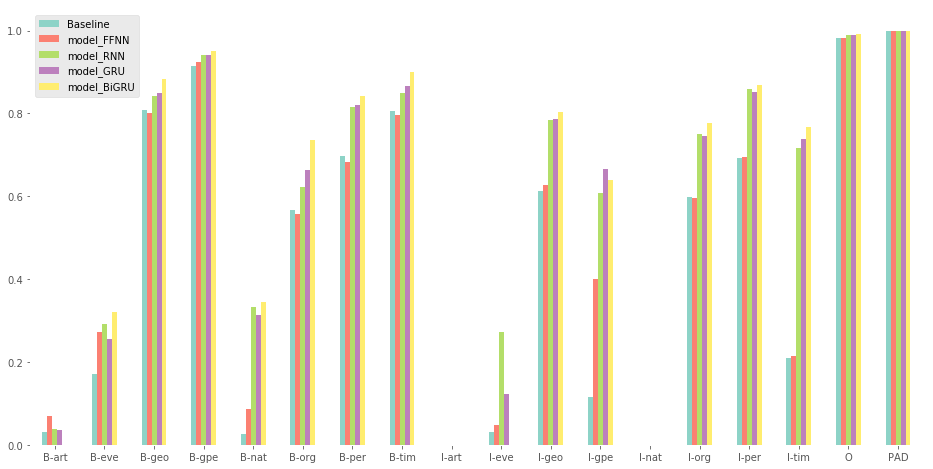

In [41]:
model_name = ['Baseline','model_FFNN', 'model_RNN', 'model_GRU', 'model_BiGRU']
group_bar(model_name)

**Based on the barplot above, for most of the tags, the baseline and FFNN model predict simiar f1_score, and the RNN, GRU and BiGRU predict higher f1_score overall. Although the BiGRU predict the highest f1_score for most of the tags, it performs worse than other models on several tags, such as 'B-art' and 'I-eve'. For some tags like 'B-art', 'I-art', 'I-nat', their f1_scores are very low among all five models. **

<span class='sub-q'>**Question 3.2**</span>

(1) Which tags have the lowest f1 score? 

For instance, you may find from the plot above that the test accuracy on "B-art", and "I-art" are very low (just an example, your case maybe different). Here is an example when models failed to predict these tags right

<img src="./data/B_art.png" alt="drawing" width="600"/>


**Based on the bar plot, 'I-art' and 'I-nat' have the lowest f1 score. **

(2) Write functions to output another example in which the tags of the lowest accuracy was predicted wrong in a sentence (include both "B-xxx" and "I-xxx" tags). Store the results in a DataFrame (same format as the above example) and use styling functions below to print out your df.

In [132]:
# reshape y_test to 2d
y_test_2d = np.argmax(y_test, axis=2)
y_test_2d.shape

(4796, 104)

In [37]:
# extract index of sentences where 'B-xxx' and 'I-xxx' tags were predicted wrong
def find_sentence(model,B_idx, I_idx):
    if model == 'Baseline':
        y_pred = baseline[X_test]
    else:
        model = load_keras_model(name)
        y_pred = model.predict_classes(X_test)
    sentence_id = []
    for i in range(len(y_test)):
        test = y_test_2d[i]
        pred = y_pred[i]
        B_art_id = np.where(test==B_idx)
        I_art_id = np.where(test==I_idx)
        if len(B_art_id[0] != 0) and \
           len(I_art_id[0] != 0) and \
           (test[B_art_id]== pred[B_art_id]).all() == False and \
           (test[I_art_id]== pred[I_art_id]).all() == False :
            sentence_id.append(i)
    return sentence_id

In [38]:
# extract intersection of sentence indexes among different models 
# which are indexes of sentences where the tags were predicted wrong in all models
def find_common_sentence(model_name_list, B_idx, I_idx):
    sentence_list = []
    for i in model_name:
        sentence_id = find_sentence(i,B_idx,I_idx)
        sentence_list.append(sentence_id)
    # get common sentences ID
    result = set(sentence_list[0])
    for s in sentence_list[1:]:
        result.intersection_update(s)
    return result  

In [39]:
# Indexes of sentences where 'I-art' and 'B-art' 
# were predicted wrong in all the five models
find_common_sentence(model_name, 0, 8) # B_art: 0, I_art: 8

{598,
 630,
 664,
 857,
 1362,
 1490,
 1938,
 1984,
 2268,
 2360,
 2379,
 2630,
 2880,
 2970,
 3734,
 4465,
 4494}

In [134]:
def create_df(model_name, idx):
    #column_name = ['Word','y_true','aseline','model_FFNN','model_RNN','model_GRU','model_BiGRU']
    tag_list = {}
    tag_list['Word'] = [idx2word[w] for w in X_test[idx]]
    tag_list['y_true'] = [idx2tag[i] for i in y_test_2d[idx]]
    for name in model_name:
        if name == 'Baseline':
            y_pred = baseline[X_test]
        else:
            model = load_keras_model(name)
            y_pred = model.predict_classes(X_test)
        tag = [idx2tag[i] for i in y_pred[idx]]
        tag_list[name]=tag
    df = pd.DataFrame(tag_list)
    return df

In [168]:
df = create_df(model_name, 630)
df

,Word,y_true,Baseline,model_FFNN,model_RNN,model_GRU,model_BiGRU
0,The,O,O,O,O,O,O
1,Olympic,O,O,O,O,O,O
2,Delivery,O,I-org,O,B-org,B-org,O
3,Authority,O,O,O,O,O,O
4,(,O,O,O,O,O,O
5,ODA,O,B-art,O,O,O,O
6,),O,O,O,O,O,O
7,said,O,O,O,O,O,O
8,Tuesday,B-tim,B-tim,B-tim,B-tim,B-tim,B-tim
9,the,O,O,O,O,O,O


In [169]:
def highlight_errors(s):
    is_max = s == s.y_true
    return ['' if v or key=='Word' else 'color: red' for key,v in is_max.iteritems()]

In [170]:
# run this cell to show you result #
df.style.apply(highlight_errors, axis=1)

,Word,y_true,Baseline,model_FFNN,model_RNN,model_GRU,model_BiGRU
0,The,O,O,O,O,O,O
1,Olympic,O,O,O,O,O,O
2,Delivery,O,I-org,O,B-org,B-org,O
3,Authority,O,O,O,O,O,O
4,(,O,O,O,O,O,O
5,ODA,O,B-art,O,O,O,O
6,),O,O,O,O,O,O
7,said,O,O,O,O,O,O
8,Tuesday,B-tim,B-tim,B-tim,B-tim,B-tim,B-tim
9,the,O,O,O,O,O,O


<span class='sub-q'>**Question 3.3**</span>

(1) Choose one of the most promising models you have built, improve this model to achieve the f1 score higher than 0.8 for as many tags as possible ( you have lots of options here, e.g. data balancing, hyperparameter tuning, changing the structure of NN, a different optimizer, ... )

(2) Explain why you choose to change certain elements of the model and how effective those adjustments are.


In [35]:
y_test_1d = y_test_2d.ravel()
y_test_1d

array([16, 16, 16, ..., 17, 17, 17])

In [111]:
unique, counts = np.unique(y_test_1d, return_counts=True)
print(np.asarray((tags, counts)).T)

[['B-art' '46']
 ['B-eve' '35']
 ['B-geo' '3797']
 ['B-gpe' '1592']
 ['B-nat' '20']
 ['B-org' '2055']
 ['B-per' '1668']
 ['B-tim' '2033']
 ['I-art' '40']
 ['I-eve' '39']
 ['I-geo' '713']
 ['I-gpe' '16']
 ['I-nat' '7']
 ['I-org' '1699']
 ['I-per' '1658']
 ['I-tim' '585']
 ['O' '88532']
 ['PAD' '394249']]


**From previous questions we know there are several tags that have very low f1 score, such as 'I-art' and 'I-nat'. Based on the results above, we can see the tags with low f1 score also has very low amount in the data set. Therefore, we can infer that the low f1 scores of those tags are due to their low amount. **

In [109]:
import tensorflow as tf

def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return 1 - K.mean(f1)

In [123]:
drop_rate=[0.1,0.3,0.5]
history_list = {}
for i in drop_rate:
    backend.clear_session()
    model=Sequential()
    model.add(Embedding(input_dim=n_words, output_dim=dim_embed, input_length=max_len))
    model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(i))
    model.add(Bidirectional(GRU(100, return_sequences=True)))
    model.add(TimeDistributed(Dense(output_dim=n_tags, activation='softmax')))

    # Compile model
    model.compile(optimizer='nadam', loss=f1_loss, metrics=['accuracy', f1], 
                                      sample_weight_mode="temporal")
    history_list[str(i)] = model.fit(X_train, y_train, batch_size=batch_size, epochs=5, 
                            validation_split=validation_split, verbose=verbose)
    store_keras_model(model, 'model_drop{}'.format(i))

/usr/share/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=18)`
  # This is added back by InteractiveShellApp.init_path()


Train on 38846 samples, validate on 4317 samples
Epoch 1/5
38846/38846 [==============================] - 355s 9ms/step - loss: 0.8987 - acc: 0.9857 - f1: 0.1012 - val_loss: 0.8941 - val_acc: 0.9875 - val_f1: 0.1059
Epoch 2/5
38846/38846 [==============================] - 352s 9ms/step - loss: 0.8928 - acc: 0.9908 - f1: 0.1071 - val_loss: 0.8931 - val_acc: 0.9892 - val_f1: 0.1069
Epoch 3/5
38846/38846 [==============================] - 351s 9ms/step - loss: 0.8918 - acc: 0.9923 - f1: 0.1081 - val_loss: 0.8927 - val_acc: 0.9898 - val_f1: 0.1072
Epoch 4/5
38846/38846 [==============================] - 352s 9ms/step - loss: 0.8913 - acc: 0.9929 - f1: 0.1087 - val_loss: 0.8924 - val_acc: 0.9902 - val_f1: 0.1076
Epoch 5/5
38846/38846 [==============================] - 352s 9ms/step - loss: 0.8909 - acc: 0.9932 - f1: 0.1090 - val_loss: 0.8924 - val_acc: 0.9904 - val_f1: 0.1075
Saved model to disk
Train on 38846 samples, validate on 4317 samples
Epoch 1/5
38846/38846 [========================

**We chose the BiGUR model for further improvement. We added a Conv1d layer and BatchNormalization layer to reduce the amount by what the hidden unit values shift around. We also changed the optimizer to 'nadam'. Considering the imbalanced data, we added 'sample_weight='temporal' in the model compile step. As our goal is to increase f1 score, we also changed the loss function to f1_loss which caculated the loss based on f1 score.            
We also tried to tune the drop_rate for the Dropout layer, and we fount drop_rate of 0.1 gives the highest f1 score.    
However, we found using f1_loss as the loss function did not improve either the accuracy or f1 score. So we still used the "categorical_crossentropy" as the loss function. **

In [127]:
    model=Sequential()
    model.add(Embedding(input_dim=n_words, output_dim=dim_embed, input_length=max_len))
    model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    model.add(Bidirectional(GRU(100, return_sequences=True)))
    model.add(TimeDistributed(Dense(output_dim=n_tags, activation='softmax')))

    # Compile model
    model.compile(optimizer='nadam', loss=loss, metrics=['accuracy', f1], 
                                      sample_weight_mode="temporal")
    history_list[str(i)] = model.fit(X_train, y_train, batch_size=batch_size, epochs=10, 
                            validation_split=validation_split, verbose=verbose)

/usr/share/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=18)`
  import sys


Train on 38846 samples, validate on 4317 samples
Epoch 1/10
38846/38846 [==============================] - 347s 9ms/step - loss: 0.0439 - acc: 0.9894 - f1: 0.1016 - val_loss: 0.0224 - val_acc: 0.9931 - val_f1: 0.1070
Epoch 2/10
38846/38846 [==============================] - 344s 9ms/step - loss: 0.0161 - acc: 0.9949 - f1: 0.1088 - val_loss: 0.0227 - val_acc: 0.9931 - val_f1: 0.1076
Epoch 3/10
38846/38846 [==============================] - 344s 9ms/step - loss: 0.0125 - acc: 0.9959 - f1: 0.1103 - val_loss: 0.0234 - val_acc: 0.9930 - val_f1: 0.1081
Epoch 4/10
38846/38846 [==============================] - 343s 9ms/step - loss: 0.0105 - acc: 0.9964 - f1: 0.1110 - val_loss: 0.0252 - val_acc: 0.9932 - val_f1: 0.1079
Epoch 5/10
38846/38846 [==============================] - 344s 9ms/step - loss: 0.0090 - acc: 0.9970 - f1: 0.1116 - val_loss: 0.0274 - val_acc: 0.9931 - val_f1: 0.1081
Epoch 6/10
38846/38846 [==============================] - 344s 9ms/step - loss: 0.0079 - acc: 0.9973 - f1: 0.11

Saved model to disk


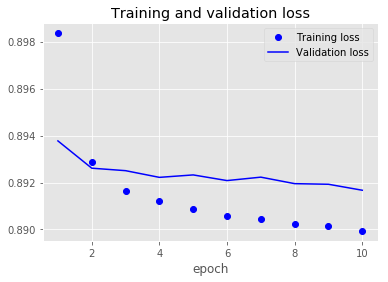

In [128]:
store_keras_model(model, 'model_new')
plot_training_history(history) 

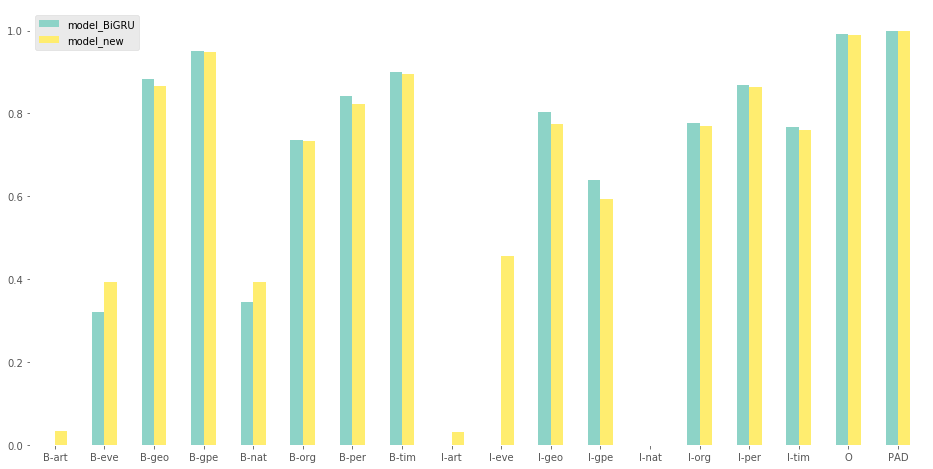

In [129]:
model_name_ = ['model_BiGRU', 'model_new']
group_bar(model_name_)

**Baesd on the plots above, although the modified model did not achieve f1 score higher than 0.8 for more tags than the original model, it did increase the f1 score for some tags, such as 'B-art', I-art', 'I-eve' and etc. I think the reason why the modified model still did not perform well enough is that the data is imbalanced. Oversampling the tags with lower ocurrence would help improve the f1 score.**